### Various factors as predictors for diabetes

Joseph Gao, Kirsten Husdal, Tony Lee and Irene Wan

### Introduction

Diabetes is a chronic condition characterized by the dysregulation of blood glucose due to abnormal insulin levels. (World Health Organization, 2022). There are two etiologies for diabetes: Type 1, an autoimmune disorder, occurs when the pancreas has reduced insulin production, whereas Type 2 is a result of decreased insulin sensitivity (Diabetes Canada, 2022). Accounting for 95% of all current diagnoses, Type 2 diabetes develops in adulthood and is comorbid with factors such as high blood pressure, high BMI and family history (Diabetes Canada, 2022). This project will explore the correlations between diabetes, and comorbid factors in an effort to produce a diagnostic tool. 

diabetes.csv contains a subset of observations collected from a larger database generated by the National Institute of Diabetes and Digestive and Kidney Diseases. The data was collected from 2016 to 2022, with all participants being females of Pima Indian heritage over 21 years of age (Khare, 2022).

The dataset has the following variables:

* `Pregnancies` – number of pregnancies
* `Glucose` – blood glucose level (mg/dL)
* `BloodPressure` – diastolic blood pressure (mm/Hg)
* `SkinThickness` – triceps skinfold thickness (mm)
* `Insulin` – insulin level in the blood (IU/mL)
* `BMI` – body mass index (kg/m2)
* `DiabetesPedigreeFunction` – likelihood of diabetes based on family history
* `Age`
* `Outcome` – whether or not the individual has diabetes (1 = yes, 0 = no)


We will investigate if it is possible to predict the outcome (if an individual has diabetes or not) given the other variables in the dataset.


In [1]:
# install leaps library
# to perform predictor subset selection
install.packages("leaps")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readr)
library(leaps)
library(patchwork)
# Limiting visible table rows
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

After examining the data, there are no rows that require cleaning. However, there are values where zero was applied as a placeholder when the value was not collected. These zeroes are found in Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age. To prevent them from influencing final calculations, these values will be filtered out. 

In [3]:
#Filtering data

urlfile <- "https://raw.githubusercontent.com/hsgao12/dsci-100-group-132/main/data/diabetes.csv"

# Set constant seed setting later seeds
SEED = 2022

diabetes_data <- read_csv(url(urlfile)) |>
                mutate(Outcome = as_factor(Outcome)) |>
                filter(Glucose != 0) |> 
                filter(BloodPressure != 0) |> 
                filter(SkinThickness != 0) |> 
                filter(Insulin != 0) |> 
                filter(BMI != 0) |> 
                filter(Age != 0) |> 
                filter(DiabetesPedigreeFunction != 0)

print("Table 1. Diagnostic factors, demographic information and diagnosis of patients")

diabetes_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1. Diagnostic factors, demographic information and diagnosis of patients"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
3,78,50,32,88,31.0,0.248,26,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,0
10,101,76,48,180,32.9,0.171,63,0
5,121,72,23,112,26.2,0.245,30,0


In [4]:
set.seed(SEED)

obs_num_outcome <- diabetes_data |>
                    group_by(Outcome) |>
                    summarize(num_obs = n())

print("Table 2. Diagnosis of patients")

obs_num_outcome

print("Outcome(1) = diagnosis, Outcome(0) = no diagnosis, num_obs = number of observations.")

[1] "Table 2. Diagnosis of patients"


Outcome,num_obs
<fct>,<int>
0,262
1,130


[1] "Outcome(1) = diagnosis, Outcome(0) = no diagnosis, num_obs = number of observations."


In [5]:
set.seed(SEED)

# splitting the data into 75% training data and 25% testing data
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

print("Table 3. Training data")
diabetes_train
print("Table 4. Testing data")
diabetes_test

means_predictors <- diabetes_train |>
    select(-Outcome) |>
    map_df(mean)

means_predictors

[1] "Table 3. Training data"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
3,126,88,41,235,39.3,0.704,27,0
1,97,66,15,140,23.2,0.487,22,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,120,80,37,150,42.3,0.785,48,1
3,187,70,22,200,36.4,0.408,36,1
1,128,88,39,110,36.5,1.057,37,1


[1] "Table 4. Testing data"


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,103,30,38,83,43.3,0.183,33,0
10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,102,44,20,94,30.8,0.400,26,0
1,109,58,18,116,28.5,0.219,22,0
0,181,88,44,510,43.3,0.222,26,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.34471,120.6519,70.88055,29.04778,149.6416,33.04403,0.5107099,30.69283


[1] "Table 5. Visualizations of the distribution of patients with or without diabetes across different predictors"


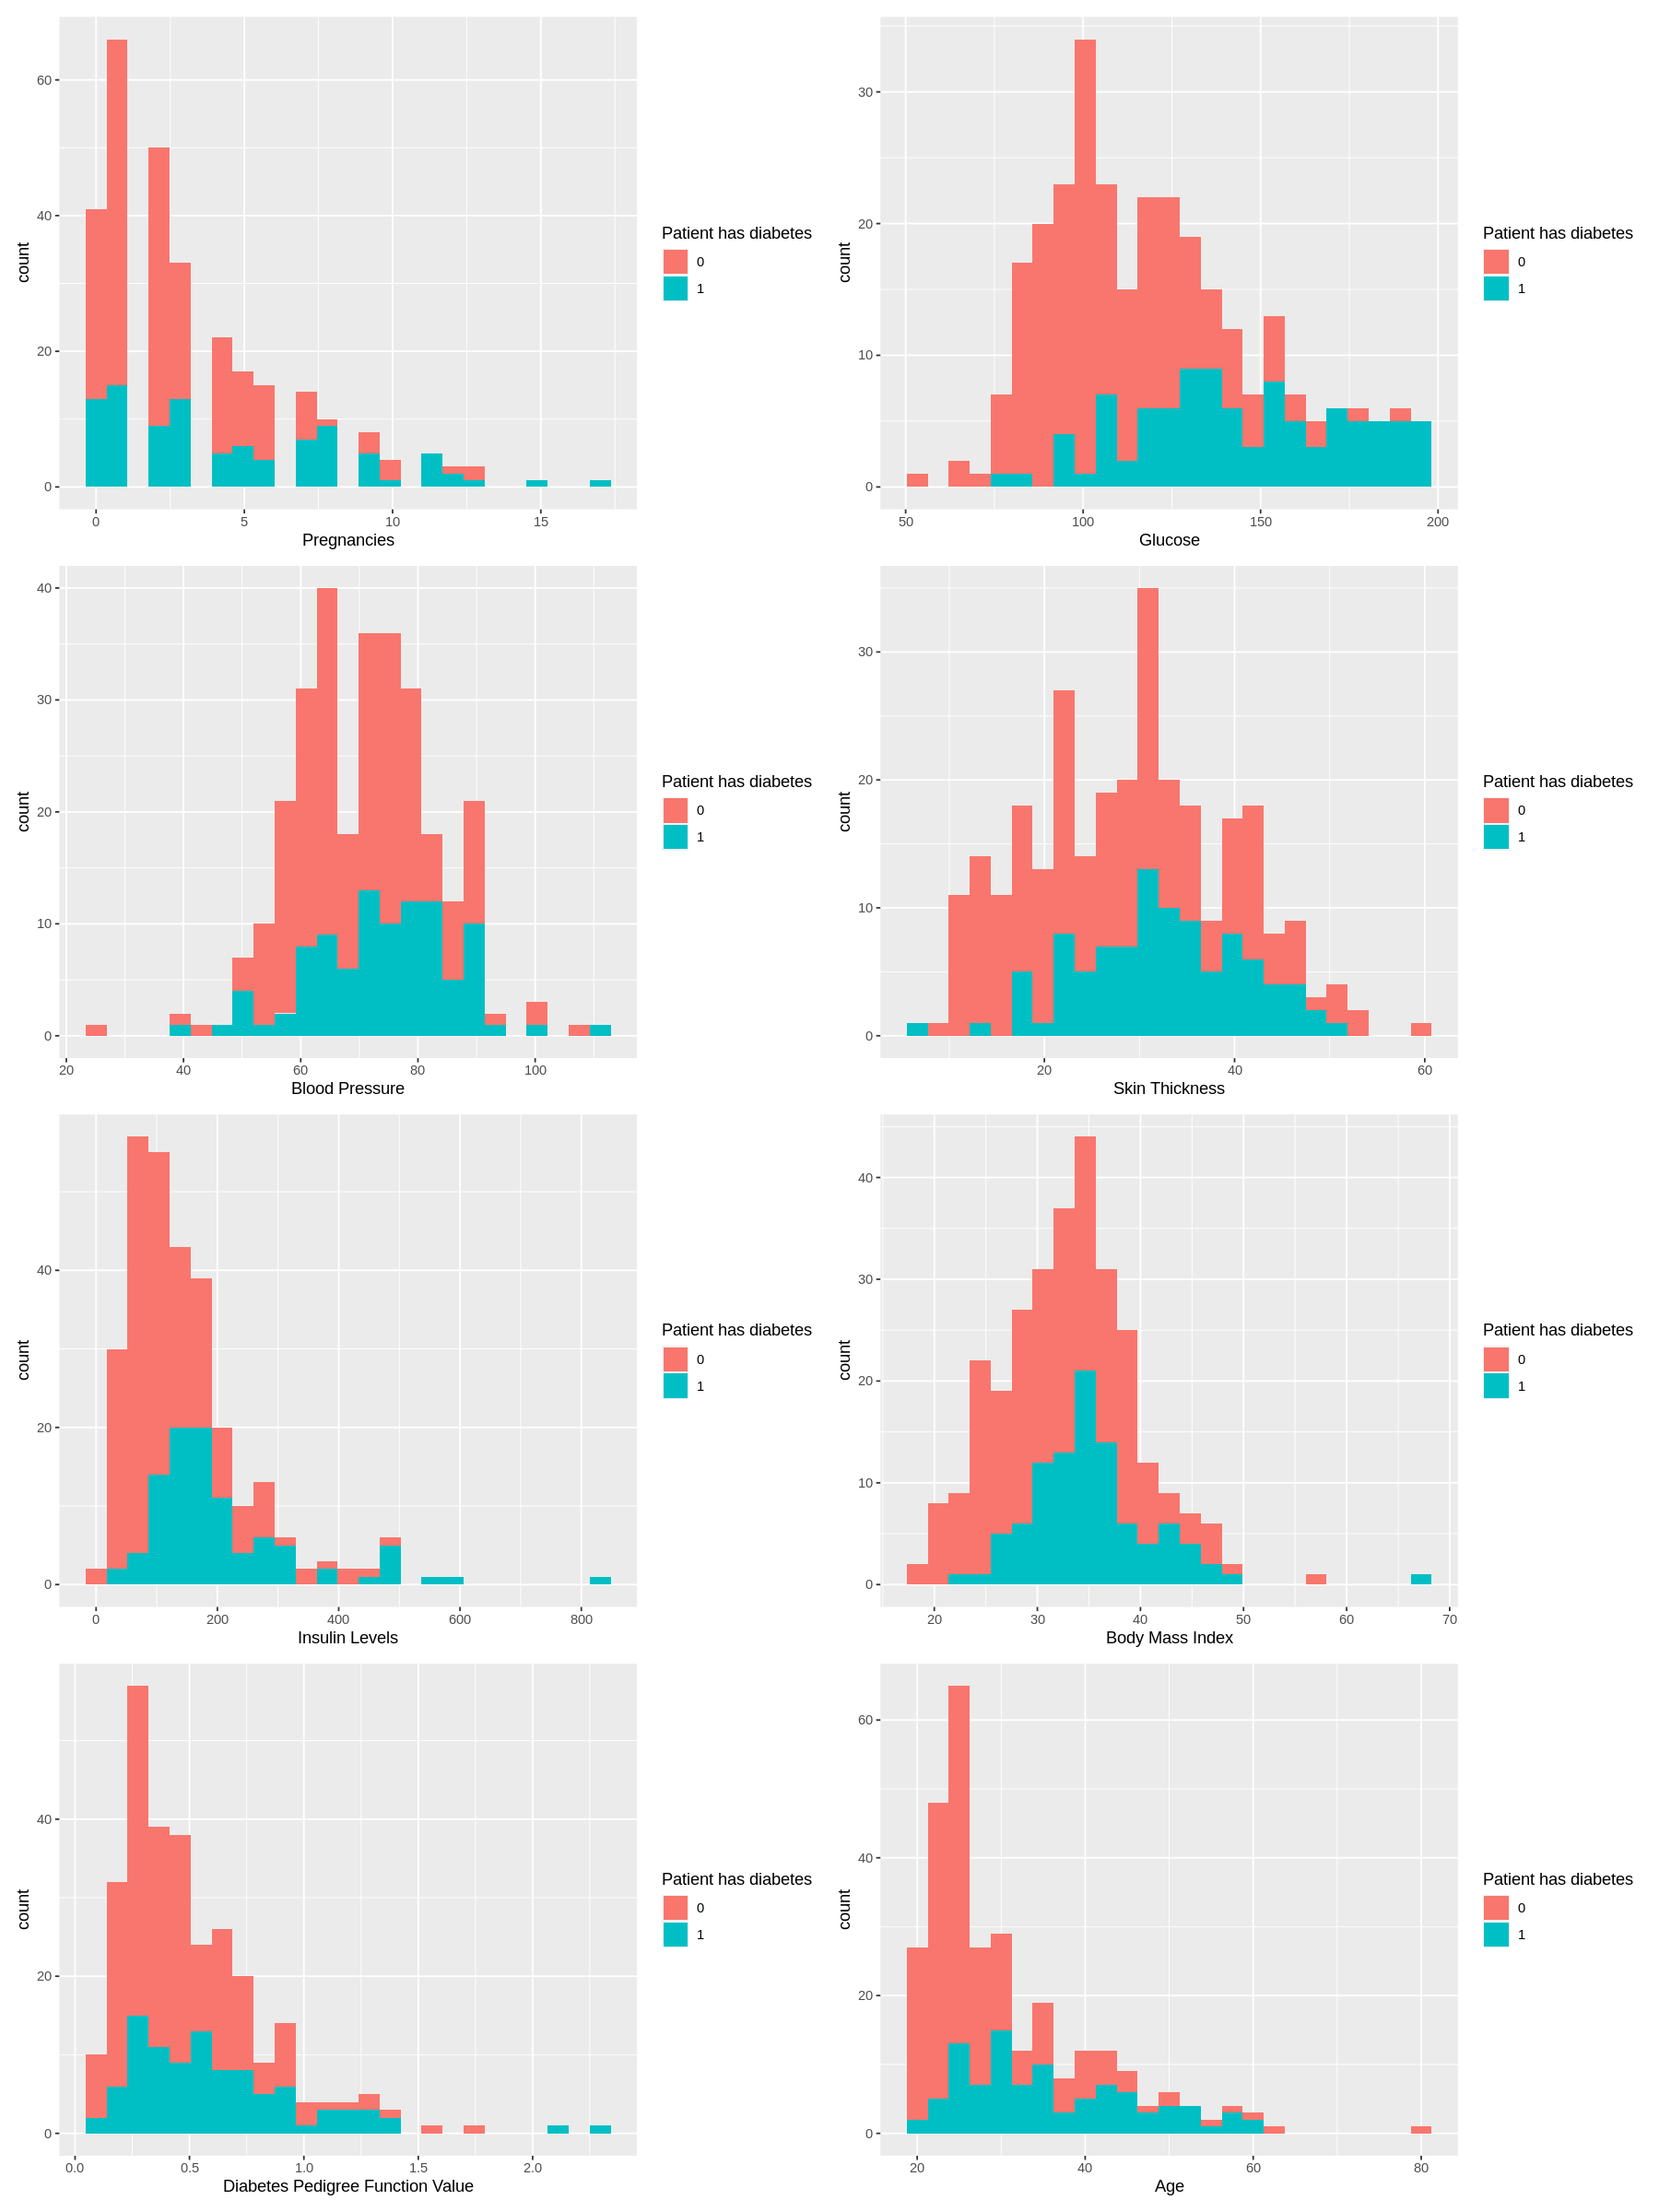

In [6]:
options(repr.plot.width = 15, repr.plot.height = 20) 

p1 <- ggplot(diabetes_train, aes(x=Pregnancies, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Pregnancies", fill="Patient has diabetes")

p2 <- ggplot(diabetes_train, aes(x=Glucose, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Glucose", fill="Patient has diabetes")

p3 <- ggplot(diabetes_train, aes(x=BloodPressure, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Blood Pressure", fill="Patient has diabetes")

p4 <- ggplot(diabetes_train, aes(x=SkinThickness, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Skin Thickness", fill="Patient has diabetes")

p5 <- ggplot(diabetes_train, aes(x=Insulin, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Insulin Levels", fill="Patient has diabetes")

p6 <- ggplot(diabetes_train, aes(x=BMI, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Body Mass Index", fill="Patient has diabetes")

p7 <- ggplot(diabetes_train, aes(x=DiabetesPedigreeFunction, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Diabetes Pedigree Function Value", fill="Patient has diabetes")

p8 <- ggplot(diabetes_train, aes(x=Age, fill=Outcome)) + 
    geom_histogram(position="stack", bins=25) + 
    labs(x="Age", fill="Patient has diabetes")

(p1 | p2) / (p3 | p4) / (p5 | p6) / (p7 | p8)
print("Table 5. Visualizations of the distribution of patients with or without diabetes across different predictors")

In [7]:
# Finding best subsets of predictors to use 
subsets <- regsubsets(Outcome~., data=diabetes_train, nvmax=8) 
summary(subsets)

Subset selection object
Call: regsubsets.formula(Outcome ~ ., data = diabetes_train, nvmax = 8)
8 Variables  (and intercept)
                         Forced in Forced out
Pregnancies                  FALSE      FALSE
Glucose                      FALSE      FALSE
BloodPressure                FALSE      FALSE
SkinThickness                FALSE      FALSE
Insulin                      FALSE      FALSE
BMI                          FALSE      FALSE
DiabetesPedigreeFunction     FALSE      FALSE
Age                          FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         Pregnancies Glucose BloodPressure SkinThickness Insulin BMI
1  ( 1 ) " "         "*"     " "           " "           " "     " "
2  ( 1 ) " "         "*"     " "           " "           " "     " "
3  ( 1 ) " "         "*"     " "           " "           " "     " "
4  ( 1 ) " "         "*"     " "           " "           " "     "*"
5  ( 1 ) "*"         "*"     " "           " "       

In [8]:
# Helper function to get formula for model of each subset 
# Source: http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/155-best-subsets-regression-essentials-in-r/

# id: model id
# object: regsubsets object
# data: data used to fit regsubsets
# outcome: outcome variable
get_model_formula <- function(id, object, outcome){
  # get models data
  models <- summary(object)$which[id,-1]
  # Get outcome variable
  #form <- as.formula(object$call[[2]])
  #outcome <- all.vars(form)[1]
  # Get model predictors
  predictors <- names(which(models == TRUE))
  predictors <- paste(predictors, collapse = "+")
  # Build model formula
  as.formula(paste0(outcome, "~", predictors))
}

In [9]:
# Helper function to get fitted model using varying formulas found from regsubsets
# Performs 5-fold cross validation across multiple k's 
# Selects best k and returns model

# id: model id 
# best_subsets: regsubsets object 
get_fitted_model <- function(id, best_subsets) {
    set.seed(SEED)
    diabetes_vfold <- vfold_cv(diabetes_train, v=5, strata=Outcome) 
    formula <- get_model_formula(id, best_subsets, "Outcome")
    
    knn_recipe <- recipe(formula, data=diabetes_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 
    
    knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 
    
    bestK <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples=diabetes_vfold, grid=10) |> 
    collect_metrics() |> 
    filter(.metric=="accuracy") |> 
    arrange(desc(mean)) |> 
    slice(1) |> 
    pull(neighbors) 
    
    knn_spec_tuned <- nearest_neighbor(weight_func="rectangular", neighbors=bestK) |> 
    set_engine("kknn") |> 
    set_mode("classification")
    
    knn_fit <- workflow() |> 
    add_recipe(knn_recipe) |> 
    add_model(knn_spec_tuned) |> 
    fit(diabetes_train)
}

In [10]:
# Helper function to get training/testing accuracy of a fitted model

# fit: Fitted model
# pred_dataset: Dataset to predict on
get_accuracy <- function(fit, pred_dataset) {
    predictions <- predict(fit, pred_dataset) |> 
    bind_cols(pred_dataset) 
    
    accuracy <- predictions |> 
               metrics(truth = Outcome, estimate = .pred_class) |>
               filter(.metric == "accuracy") |> 
               pull(.estimate)
}

In [11]:
# Find the training accuracies for each optimal subset
subset_size <- c() 
training_accuracies <- c() 
for (i in 1:8) {
    fitted_model <- get_fitted_model(i, subsets) 
    subset_size <- append(subset_size, i) 
    training_accuracy <- get_accuracy(fitted_model, diabetes_train)
    training_accuracies <- append(training_accuracies, training_accuracy) 
}

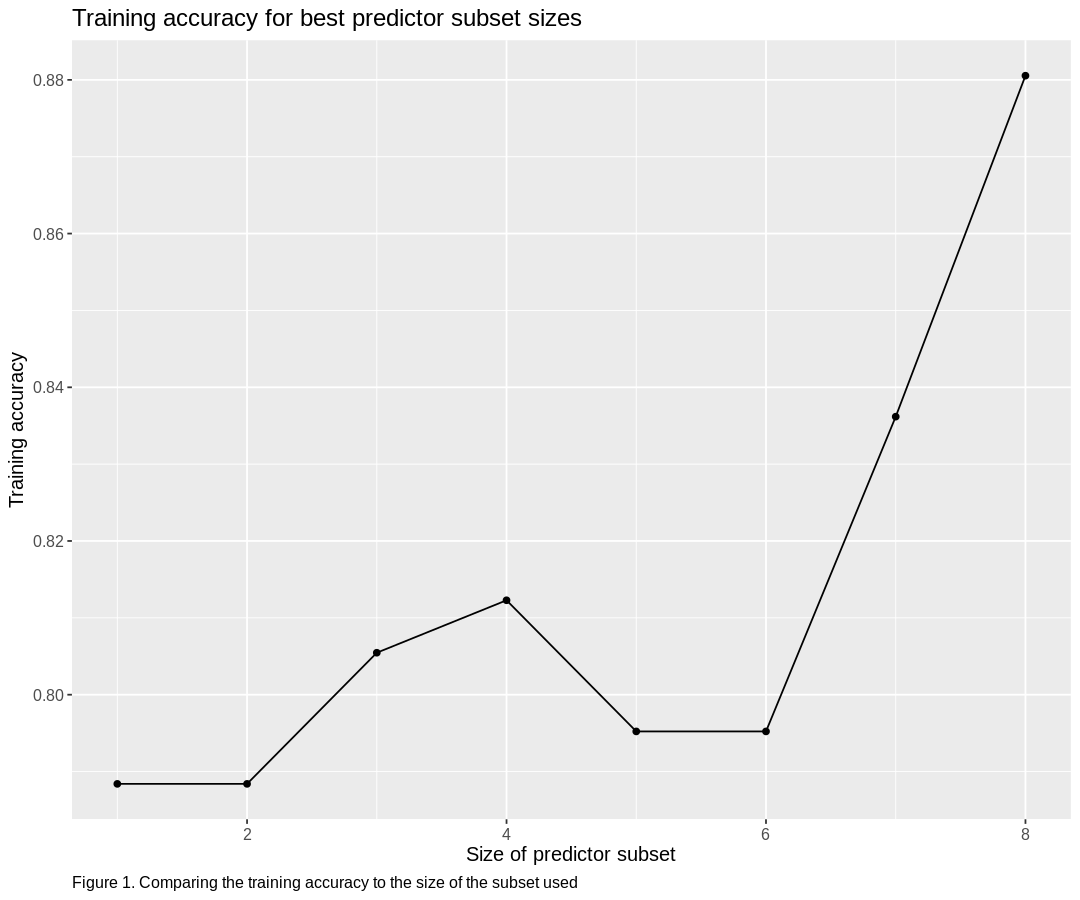

In [12]:
options(repr.plot.height = 7.5, repr.plot.width = 9)

# Create dataframe using subset size and training accuracies
accuracy_data <- data.frame(subset_size, training_accuracies) 

# Create plot of subset size vs training accuracy 
accuracy_plot <- ggplot(accuracy_data, aes(x=subset_size, y=training_accuracies)) + 
geom_point() + 
geom_line() + 
labs(x="Size of predictor subset", y="Training accuracy",
     caption="Figure 1. Comparing the training accuracy to the size of the subset used") + 
ggtitle("Training accuracy for best predictor subset sizes") +
theme(text = element_text(size = 12),
      plot.caption = element_text(hjust = 0))

accuracy_plot

As we can see from above, using all predictors seem to have the best training accuracy. So, we will use all predictors to predict on our testing set. 

In [13]:
# Find test accuracy using all predictors
fitted_model <- get_fitted_model(8, subsets) 
test_accuracy <- get_accuracy(fitted_model, diabetes_test) 
test_accuracy

[1] 0.7676768

In [14]:
set.seed(SEED)
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = Outcome)

In [15]:
knn_recipe <- recipe(Outcome ~ ., data = diabetes_train) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

In [17]:
set.seed(SEED)

# testing k = 1 though 20
k_vals <- tibble(neighbors = seq(from = 1, to =20))

knn_results <- workflow() |>
               add_recipe(knn_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               arrange(desc(mean))
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model03
4,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model04
9,accuracy,binary,0.7675959,5,0.02963416,Preprocessor1_Model09
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.7574245,5,0.02324299,Preprocessor1_Model12
1,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model01
2,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model02


In [18]:
neighbor <- knn_results |> slice(1) |> pull(neighbors)
neighbor

[1] 3

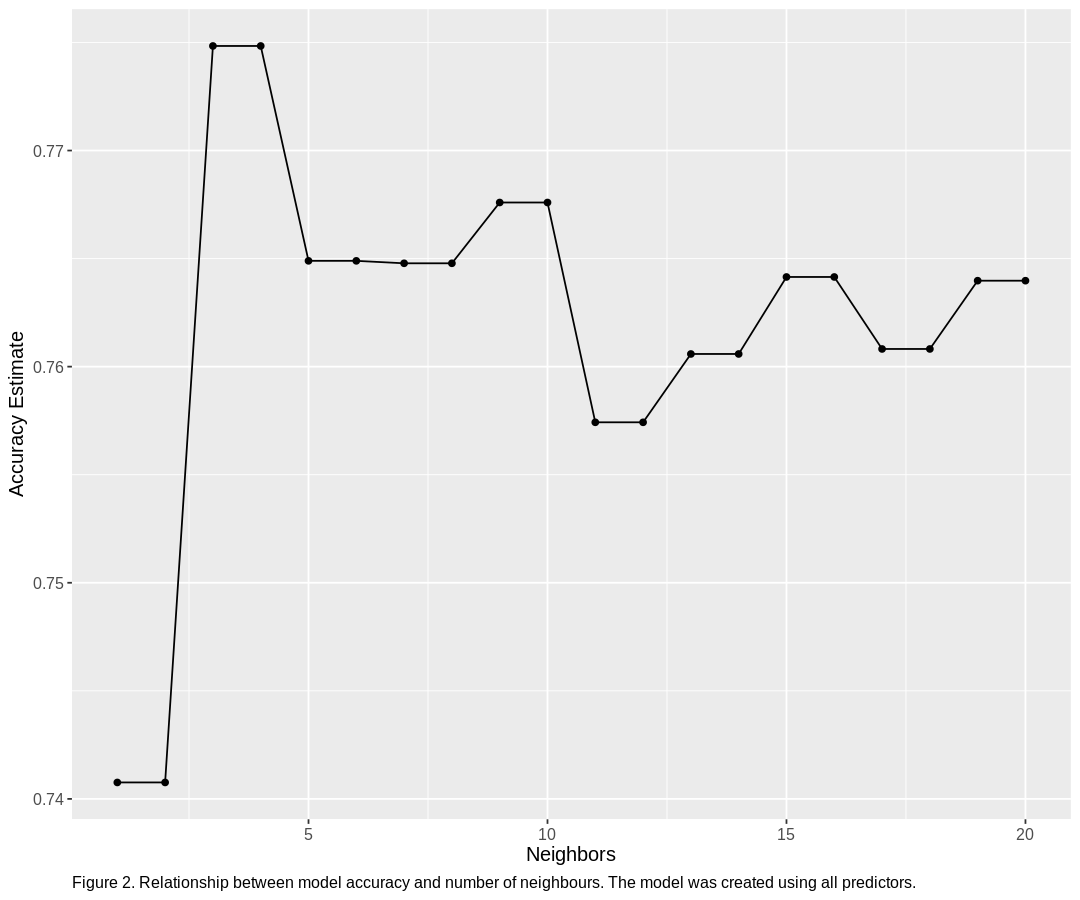

In [19]:
options(repr.plot.height = 7.5, repr.plot.width = 9)

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate", 
                         caption = "Figure 2. Relationship between model accuracy and number of neighbours. The model was created using all predictors.") +
                    theme(text = element_text(size = 12),
                          plot.caption = element_text(hjust = 0)) 

cross_val_plot

In [20]:
diabetes_recipe <- recipe(Outcome ~., data = diabetes_train)

diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
               set_engine("kknn") |>
               set_mode("classification")

diabetes_fit <- workflow() |>
             add_recipe(diabetes_recipe) |>
             add_model(diabetes_spec) |>
             fit(data = diabetes_train)

diabetes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.225256
Best kernel: rectangular
Best k: 3

In [21]:
set.seed(SEED) 

diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
                    bind_cols(diabetes_test)

diabetes_predictions

.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5,166,72,19,175,25.8,0.587,51,1
0,1,103,30,38,83,43.3,0.183,33,0
1,10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,3,102,44,20,94,30.8,0.400,26,0
0,1,109,58,18,116,28.5,0.219,22,0
0,0,181,88,44,510,43.3,0.222,26,1


In [22]:
diabetes_metrics <- diabetes_predictions |> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

print("Table 6. Model degree of accuracy")
diabetes_metrics
print(".metric = statistic measured, .estimator = measurement type, .estimate = degree of metric")

[1] "Table 6. Model degree of accuracy"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7676768


[1] ".metric = statistic measured, .estimator = measurement type, .estimate = degree of metric"


In [23]:
mnist_conf_mat <- diabetes_predictions |>
                    conf_mat(truth = Outcome, estimate = .pred_class)

print("Table 7. A signal detection matrix measuring hits, misses, false alarms and correct rejections.")
mnist_conf_mat

[1] "Table 7. A signal detection matrix measuring hits, misses, false alarms and correct rejections."


          Truth
Prediction  0  1
         0 55 12
         1 11 21

### Discussion

### References

Diabetes Canada. (2017). Diabetes Canada 2018 Pre-Budget Submission: 90-90-90 - Measurable change and improved productivity by 2021. Retrieved from Diabetes Canada: https://www.diabetes.ca/DiabetesCanadaWebsite/media/Advocacy-and-Policy/Submissions%20to%20Government/Federal/2018-Federal-PBS.pdf

Diabetes Canada. (2022). Assess your risk of developing diabetes. DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/type-2-risks/risk-factors---assessments 

Diabetes Canada. (2022). What is diabetes? DiabetesCanadaWebsite. Retrieved October 27, 2022, from https://www.diabetes.ca/about-diabetes/what-is-diabetes 

Holman, R. R., Paul, S. K., Bethel, M. A., Matthews, D. R., & Neil, H. A. (2008). 10-year follow-up of intensive glucose control in type 2 diabetes. New England Journal of Medicine, 359(15), 1577–1589. https://doi.org/10.1056/nejmoa0806470 

Khare, A. D. (2022, April 8). Diabetes Dataset. Retrieved October 20, 2022, from https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset.
Version 1

Schneider, T., Gomes, T., Hayes, K. N., Suda, K. J., & Tadrous, M. (2022). Comparisons of insulin spending and price between Canada and the United States. Mayo Clinic Proceedings, 97(3), 573–578. https://doi.org/10.1016/j.mayocp.2021.11.028 

Spencer Bonilla, G., Rodriguez-Gutierrez, R., & Montori, V. M. (2016). What we don’t talk about when we talk about preventing type 2 diabetes—addressing socioeconomic disadvantage. JAMA Internal Medicine, 176(8), 1053. https://doi.org/10.1001/jamainternmed.2016.2952 

World Health Organization. (n.d.). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/health-topics/diabetes#tab=tab_3 

World Health Organization. (2022, September 16). Diabetes. World Health Organization. Retrieved October 27, 2022, from https://www.who.int/news-room/fact-sheets/detail/diabetes 